In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## Text Processing and Dates

In [ ]:
!cat log.txt

In [ ]:
lines = open('log.txt').readlines()
first = lines[0]
first

String manipulation based on character positions.

In [ ]:
time_str = first.split('[', 1)[1].split(' ', 1)[0]
day, month, rest = time_str.split('/')
year, hour, minute, second = rest.split(':')
year, month, day, hour, minute, second

In [ ]:
time_strs = (pd.Series(lines).str.split('[', 1, expand=True)[1]
             .str.split(' ', 1, expand=True)[0])
day_month_rest = time_strs.str.split('/', expand=True)
pd.concat([day_month_rest.loc[:, 0:1], 
           day_month_rest[2].str.split(':', expand=True)], axis=1)

String manipulation based on regular expressions.

In [ ]:
import re
pattern = r'(\d+)/(\w+)/(\d+):(\d+):(\d+):(\d+)'
day, month, year, hour, minute, second = re.search(pattern, first).groups()
year, month, day, hour, minute, second

In [ ]:
pd.Series(lines).str.extract(pattern)

Date parsing using the `datetime` module.

In [ ]:
from datetime import datetime
datetime.strptime(time_str, '%d/%b/%Y:%H:%M:%S')

In [ ]:
pd.Series(lines).str.extract(r'\[(.*) -0800\]')[0].apply(
    lambda s: datetime.strptime(s, '%d/%b/%Y:%H:%M:%S'))

## Text Processing Case Study

In this example, we will apply string processing to the process of data cleaning and exploratory data analysis.

### Getting the Data

The city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).

<img src="calls_desc.png" width=800px />



In [3]:
import ds100_utils

calls_url = 'https://data.cityofberkeley.info/api/views/k2nh-s5h5/rows.csv?accessType=DOWNLOAD'
calls_file = ds100_utils.fetch_and_cache(calls_url, 'calls.csv')
calls = pd.read_csv(calls_file, warn_bad_lines=True)
calls.head()

Using cached version that was downloaded (UTC): Thu Feb 14 18:31:38 2019


,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,18091151,IDENTITY THEFT,07/12/2018 12:00:00 AM,08:45,FRAUD,4,02/14/2019 09:31:00 AM,"2700 SHASTA RD\nBerkeley, CA\n(37.885559, -122...",2700 SHASTA RD,Berkeley,CA
1,18043498,ROBBERY,08/02/2018 12:00:00 AM,18:15,ROBBERY,4,02/14/2019 09:31:00 AM,"OXFORD STREET &amp; ALLSTON WY\nBerkeley, CA\n...",OXFORD STREET & ALLSTON WY,Berkeley,CA
2,18063390,BURGLARY AUTO,11/12/2018 12:00:00 AM,11:45,BURGLARY - VEHICLE,1,02/14/2019 09:31:04 AM,"1700 FOURTH ST\nBerkeley, CA\n(37.871883, -122...",1700 FOURTH ST,Berkeley,CA
3,18036494,ROBBERY,06/28/2018 12:00:00 AM,20:00,ROBBERY,4,02/14/2019 09:31:00 AM,"WEBSTER STREET &amp; HILLEGASS AV\nBerkeley, C...",WEBSTER STREET & HILLEGASS AV,Berkeley,CA
4,18037878,BURGLARY RESIDENTIAL,06/30/2018 12:00:00 AM,08:00,BURGLARY - RESIDENTIAL,6,02/14/2019 09:31:00 AM,"1200 CORNELL AVE\nBerkeley, CA\n(37.882739, -1...",1200 CORNELL AVE,Berkeley,CA


How many records did we get?

In [4]:
len(calls)

4337

What does an example `Block_Location` value look like?

In [5]:
print(calls['Block_Location'].iloc[0])

2700 SHASTA RD
Berkeley, CA
(37.885559, -122.258485)


### Preliminary observations on the data?

1. `EVENTDT` -- Contains the incorrect time
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Encodes the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- a multi-line string that contains coordinates.**
1. `BLKADDR` -- Appears to be the address in `Block Location`.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.

### Extracting locations

The block location contains geographic coordinates. Let's extract them.

In [6]:
calls['Block_Location'][0]

'2700 SHASTA RD\nBerkeley, CA\n(37.885559, -122.258485)'

In [7]:
calls_lat_lon = (
    calls['Block_Location']
    .str.extract("\((\d+\.\d+)\, (-\d+\.\d+)\)")
)
calls_lat_lon.columns = ['Lat', 'Lon']
calls_lat_lon.head(10)

,Lat,Lon
0,37.885559,-122.258485
1,37.869652,-122.265882
2,37.871883,-122.301255
3,37.855824,-122.25502
4,37.882739,-122.293754
5,37.850809,-122.291042
6,37.85177,-122.276489
7,37.869764,-122.28655
8,37.873865,-122.300777
9,37.879933,-122.283098


How many records have missing values?

In [8]:
calls_lat_lon.isnull().sum()

Lat    167
Lon    167
dtype: int64

Examine the missing values.

In [10]:
calls[calls_lat_lon.isnull().any(axis=1)]['Block_Location'].head(10)

14     37.8684950000000000, -122.2694450000000000\nBe...
49                       200 TANGLEWOOD RD\nBerkeley, CA
59                           600 BONNIE LN\nBerkeley, CA
76        UNIVERSITY AV &amp; EASTSHORE BL\nBerkeley, CA
124                       700 WHITAKER AVE\nBerkeley, CA
140                   2100 M L KING JR WAY\nBerkeley, CA
147                    1600 SIXTY-THIRD ST\nBerkeley, CA
180                   2700 M L KING JR WAY\nBerkeley, CA
236          FULTON STREET &amp;DURANT AVE\nBerkeley, CA
240         SHATTUCK AVENUE &amp;CENTER ST\nBerkeley, CA
Name: Block_Location, dtype: object

Join in the extracted values.

In [11]:
if 'Lat' not in calls.columns:
    calls = calls.merge(calls_lat_lon, left_index=True, right_index=True)
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Lat,Lon
0,18091151,IDENTITY THEFT,07/12/2018 12:00:00 AM,08:45,FRAUD,4,02/14/2019 09:31:00 AM,"2700 SHASTA RD\nBerkeley, CA\n(37.885559, -122...",2700 SHASTA RD,Berkeley,CA,37.885559,-122.258485
1,18043498,ROBBERY,08/02/2018 12:00:00 AM,18:15,ROBBERY,4,02/14/2019 09:31:00 AM,"OXFORD STREET &amp; ALLSTON WY\nBerkeley, CA\n...",OXFORD STREET & ALLSTON WY,Berkeley,CA,37.869652,-122.265882
2,18063390,BURGLARY AUTO,11/12/2018 12:00:00 AM,11:45,BURGLARY - VEHICLE,1,02/14/2019 09:31:04 AM,"1700 FOURTH ST\nBerkeley, CA\n(37.871883, -122...",1700 FOURTH ST,Berkeley,CA,37.871883,-122.301255
3,18036494,ROBBERY,06/28/2018 12:00:00 AM,20:00,ROBBERY,4,02/14/2019 09:31:00 AM,"WEBSTER STREET &amp; HILLEGASS AV\nBerkeley, C...",WEBSTER STREET & HILLEGASS AV,Berkeley,CA,37.855824,-122.25502
4,18037878,BURGLARY RESIDENTIAL,06/30/2018 12:00:00 AM,08:00,BURGLARY - RESIDENTIAL,6,02/14/2019 09:31:00 AM,"1200 CORNELL AVE\nBerkeley, CA\n(37.882739, -1...",1200 CORNELL AVE,Berkeley,CA,37.882739,-122.293754


## Examining Location information

Let's examine the geographic data (latitude and longitude).  Recall that we had some missing values.  Let's look at the behavior of these missing values according to crime type.

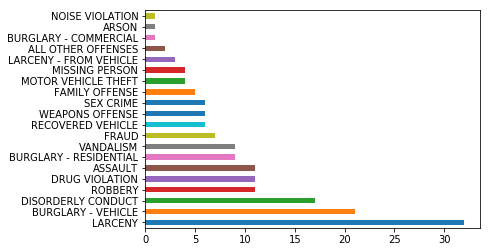

In [12]:
missing_lat_lon = calls[calls[['Lat', 'Lon']].isnull().any(axis=1)]
missing_lat_lon['CVLEGEND'].value_counts().plot(kind='barh');

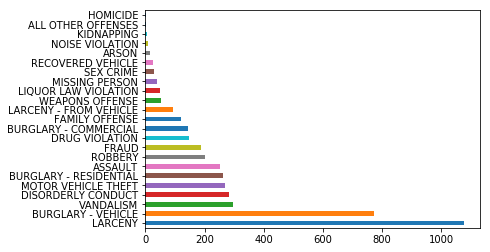

In [13]:
calls['CVLEGEND'].value_counts().plot(kind='barh');

### Observations?

There is a clear bias towards drug violations that is not present in the original data.  Therefore we should be careful when dropping missing values!

We might further normalize the analysis by the frequency to find which type of crime has the highest proportion of missing values.

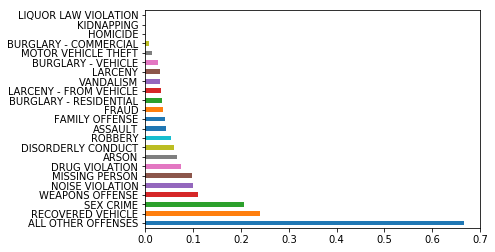

In [14]:
(missing_lat_lon['CVLEGEND'].value_counts() 
 / calls['CVLEGEND'].value_counts()
).sort_values(ascending=False).plot(kind="barh");

Now, let's make a crime map.

In [15]:
import folium
import folium.plugins

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
locs = calls[['Lat', 'Lon']].astype('float').dropna().values
heatmap = folium.plugins.HeatMap(locs.tolist(), radius=10)
sf_map.add_child(heatmap)

### Questions

1. Is campus really the safest place to be?
1. Why are all the calls located on the street and at often at intersections?


In [17]:
locations = calls[calls['CVLEGEND'] == 'ASSAULT'][['Lat', 'Lon']]

cluster = folium.MarkerCluster([])
for _, r in locations.dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Lon"])]))
    
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
sf_map.add_child(cluster)
sf_map